### **NLP**

### présentation projet:
- sujet E : **Identification des tendances de recherche médicale: Analyser les publications scientifiques pour identifier les tendances actuelles de la recherche médicale et les domaines émergents.**

- Choisir un domaine scientifique et des données sur plusieurs articles
- analyser les données textuelles sur ces articles


### A rendre: **Vendredi 9 juin** (mail : naima.oubenali@univ-lille.fr)
- Un rapport de 3 pages (sources des données, choix du modèle, résultats, etc...)
- Le code à déposer sur git (code dans un zip file)
- Une présentation ppt (visualisation, etc..)

In [ ]:
### Packages

!pip install nltk
!pip install spacy
!pip install regex
!pip install textblob
!pip install Bio
!pip install gensim

In [7]:
# Répertoire de travail
import os
os.chdir(r'D:\M2DSS\Projets_python')

### <span style="color:darkblue"> **1) Web Scrapping sur les publications pubmed en génétique**  </span>

In [ ]:
import requests
from bs4 import BeautifulSoup

# URL de la page de recherche (paramétré à 200 articles par page)
base_url = 'https://pubmed.ncbi.nlm.nih.gov/'

nb_pages = 200
urls = ['{}?term=genetics&page={}'.format(base_url, page) for page in range(1, nb_pages + 1)]

articles = []
    
# Parcourir toutes les pages de l'URL
for url in urls:
    # l'URL de la page à récupérer
    # print(url) 

    # Obtenir le contenu html de la page
    response = requests.get(url)

    # Analyse du contenu html
    soup = BeautifulSoup(response.content, 'html.parser')
    content = soup.get_text()

    # Une boucle pour stocker le titre, l'auteur, année de publication et le résumé dans un dicionnaire  
    for article in soup.find_all('div', class_= 'docsum-content'):

        # Titre de l'article
        title = article.find('a', class_= 'docsum-title').get_text().strip()

        # Auteur de l'article
        authors = article.find('span', class_= 'docsum-authors').get_text().strip()

        # Date de publication
        pub_date = article.find('span', class_= 'docsum-journal-citation').get_text().strip()

        # Résumé de l'article
        abstract = article.find('div', class_= 'full-view-snippet').get_text().strip()

        articles.append({'title': title, 'authors': authors, 'pub_date': pub_date, 'abstract': abstract}) 
        
print(articles)

In [8]:
# Chargement des libraries

import argparse
import math
from Bio import Entrez
import requests
from bs4 import BeautifulSoup
import string
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from collections import  Counter
from wordcloud import WordCloud
from textwrap import wrap

In [ ]:
# Function to search for a query term in the PubMed database.
# Returns a list of paper IDs that match the query.
def search(query):
    # Set the email to be used with the Entrez API
    Entrez.email = 'arnaudval1014@gmail.com'
    
    # Search the PubMed database for the query term
    handle = Entrez.esearch(db='pubmed',
                            sort='relevance',
                            retmax='250000',
                            retmode='xml',
                            term=query)
    
    # Parse the results
    results = Entrez.read(handle)
    
    return results

# Fetching the list of studies related to the term 'Disease'
studies = search('Genetics')

# Extracting the list of IDs from the search results
studiesIdList = studies['IdList']

# Function to fetch details of a list of studies based on their IDs.
# Returns a dictionary with the details of the studies.
def fetch_details(id_list):
    # Join the list of IDs into a comma-separated string
    ids = ','.join(id_list)
    
    # Set the email to be used with the Entrez API
    Entrez.email = 'arnaudval1014@gmail.com'
    
    # Fetch the details of the studies
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=ids)
    
    # Parse the results
    results = Entrez.read(handle)
    
    return results

# Creating empty lists to store the details of the studies
title_list = []
abstract_list = []
journal_list = []
language_list = []
pubdate_year_list = []
pubdate_month_list = []

# Fetch the details of the studies
studies = fetch_details(studiesIdList)

# Define the chunk size for batching the fetch requests
chunk_size = 100

# For each chunk of IDs
for chunk_i in range(0, len(studiesIdList), chunk_size):
    # Get the current chunk of IDs
    chunk = studiesIdList[chunk_i:chunk_i + chunk_size]
    
    # Fetch the details of the studies in the current chunk
    papers = fetch_details(chunk)
    
    # For each paper in the chunk
    for i, paper in enumerate(papers['PubmedArticle']):
        # Extract and store the title, abstract, journal, language, and publication date of the paper
        title_list.append(paper['MedlineCitation']['Article']['ArticleTitle'])
        
        try:
            abstract_list.append(paper['MedlineCitation']['Article']['Abstract']['AbstractText'][0])
        except:
            abstract_list.append('No Abstract')
        
        journal_list.append(paper['MedlineCitation']['Article']['Journal']['Title'])
        language_list.append(paper['MedlineCitation']['Article']['Language'][0])
        
        try:
            pubdate_year_list.append(paper['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Year'])
        except:
            pubdate_year_list.append('No Data')
        
        try:
            pubdate_month_list.append(paper['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Month'])
        except:
            pubdate_month_list.append('No Data')

# Combine the lists into a DataFrame
df = pd.DataFrame(list(zip(title_list, abstract_list, journal_list, language_list, pubdate_year_list, pubdate_month_list)),
                  columns=['Title', 'Abstract', 'Journal', 'Language', 'Year', 'Month'])

df.to_csv('pubmed_genetic_studies.csv', index = False)

In [ ]:
print('Nombre total d\'articles bruts: {:}\n'.format(len(articles)))

In [ ]:
# Une liste de mots-clés recherchés sur internet dans le cadre des recherche en génétique
mots_cles = ['Gene editing', 'Genome editing', 'Personalized medicine', 'Next-generation sequencing', 'Transcriptomics',\
             'Epigenetics', 'Biomarkers', 'Functional genomics', 'Proteomics', 'Metabolomics', 'Single-cell sequencing', 'Gene therapy', 'Genetic testing',\
             'Genome-wide association study (GWAS)', 'Polygenic risk score', 'Pharmacogenomics', 'Immunogenetics']


# Initialiser un dictionnaire pour compter le nombre d'articles pour chaque mot-clé
nb_mots_cles = {mot_cle: 0 for mot_cle in mots_cles}

# Nombre d'occurrences de chaque mot-clé dans le titre de l'article
for mot_cle in mots_cles:
    title_occurrences = content.lower().count(mot_cle.lower())
    nb_mots_cles[mot_cle] += title_occurrences
    content_occurrences = content.lower().count(mot_cle.lower())
    nb_mots_cles[mot_cle] += content_occurrences

for mot_cle in mots_cles:
    print(mot_cle + ': ' + str(nb_mots_cles[mot_cle]))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


plt.figure(figsize = (15,8))
sns.set_theme(style = "darkgrid")
sns.barplot(x = list(nb_mots_cles.keys()), y = list(nb_mots_cles.values()), palette = 'Dark2')
plt.xticks(rotation = 80, fontsize = 15)
plt.yticks(fontsize = 10)
plt.xlabel("Mots clés", fontsize = 15)
plt.ylabel("Nombre d'occurrences", fontsize = 15)
plt.title("Tendances actuelles en recherche médicale dans le domaine de la génétique".upper(), fontsize = 18, fontweight = 'bold', color = 'darkblue')
plt.show()

### <span style="color:darkblue"> * Mise en forme et pré-nettoyage des données </span>

In [9]:
import pandas as pd

df = pd.read_csv('pubmed_genetic_studies.csv', sep = ';')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.drop(['Language', 'Month'], axis = 1)
df.head()

Title  \
0                                    Human genetics.   
1                            The genetics of health.   
2          Genetics of complex traits in psychiatry.   
3  Integrating genetic and non-genetic determinan...   
4          Speciation genetics: evolving approaches.   

                                            Abstract  \
0                                        No Abstract   
1  Recent experience with several high-profile dr...   
2  Virtually all psychiatric traits are genetical...   
3  Cancer represents an evolutionary process thro...   
4  Much progress has been made in the past two de...   

                     Journal  Year  
0  Annual review of genetics  1970  
1            Nature genetics  2006  
2      Biological psychiatry  2015  
3   Nature reviews. Genetics  2021  
4   Nature reviews. Genetics  2006

In [10]:
# Filtre sur les lignes contenant que des chiffres
df = df[df['Year'].str.match(r'[0-9]').fillna(False)]

In [11]:
# Suppression des lignes de 'Year' non conformes
df = df[df['Year'].str.len() == 4]

In [12]:
# Vérification du type de la variable 'Year'
df['Year'].info()

<class 'pandas.core.series.Series'>
Index: 8038 entries, 0 to 9998
Series name: Year
Non-Null Count  Dtype 
--------------  ----- 
8038 non-null   object
dtypes: object(1)
memory usage: 125.6+ KB


In [13]:
# Conversion la variable 'Year' en 'int'
df['Year'] = df['Year'].astype(int)

In [14]:
# Filter les années de publications à partir de 2016
df = df[df['Year'] >= 2016]
df.reset_index(drop = True, inplace = True)
len(df)

1766

### <span style="color:darkblue"> **2) Nettoyage des données**  </span>

In [15]:
# Vérification des cellules vides
df.isnull().sum()

Title       0
Abstract    0
Journal     0
Year        0
dtype: int64

In [16]:
# Suppression des articles ne contenant pas de résumé
df = df[(df['Abstract'] != 'No Abstract')]

In [17]:
print('Nombre total d\'articles après nettoyage pour l\'analyse: {:}\n'.format(len(df)))

Nombre total d'articles après nettoyage pour l'analyse: 1533



In [18]:

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
  # remove punctuations
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_newlines(text):
  # Remove newlines and extra whitespaces
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
def remove_digits(text):
    # remove numbers and digits
    text = re.sub(r'[0-9]', '', text)
    return text

In [19]:
df['Abstract'] = df['Abstract'].apply(lambda x: remove_URL(x))
df['Abstract'] = df['Abstract'].apply(lambda x: remove_emoji(x))
df['Abstract'] = df['Abstract'].apply(lambda x: remove_html(x))
df['Abstract'] = df['Abstract'].apply(lambda x: remove_punct(x))
df['Abstract'] = df['Abstract'].apply(lambda x: remove_digits(x))

In [20]:
# More cleaning

def remove_repetitive_letters(text):
    pattern = r'(\w)\1{2,}'  # Matches a letter repeated more than 2 times
    cleaned_text = re.sub(pattern, r'\1', text)
    return cleaned_text

df['Abstract'] = df['Abstract'].apply(lambda x: remove_repetitive_letters(x))

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict = contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['Abstract'] = df['Abstract'].apply(lambda x: expand_contractions(x))

### <span style="color:darkblue"> * Enlever les stop-words  </span>

In [21]:
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arnau\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\arnau\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [22]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arnau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arnau\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
def clean_text(text):  
    
    
    # Convert to lowercase
    text = text.lower()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    text = ' '.join([token for token in tokens if token not in stop_words])
    
    return text
    

df['Abstract'] = df['Abstract'].apply(lambda x: clean_text(x))

In [24]:
df.head()

Title  \
0  Integrating genetic and non-genetic determinan...   
1  Mouse Genetic Reference Populations: Cellular ...   
2  [The development of genetics teaching in China...   
3  Robust Findings From 25 Years of PTSD Genetics...   
6  Genomics-assisted breeding for pigeonpea impro...   

                                            Abstract  \
0  cancer represents evolutionary process growing...   
1  interrogation diseaserelevant cellular molecul...   
2  chinese genetics educators carried comprehensi...   
3  purpose review contextualize findings first ye...   
6  review outlines advances pigeonpea genomics br...   

                                             Journal  Year  
0                           Nature reviews. Genetics  2021  
1                           Trends in genetics : TIG  2021  
2                               Yi chuan = Hereditas  2018  
3                         Current psychiatry reports  2018  
6  TAG. Theoretical and applied genetics. Theoret...  2020

In [25]:
# Lémmatisation

stemmer = SnowballStemmer('english')
def lemmatize_stemming(text) :
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='n'))

In [26]:
def preprocess(text):
    corpus = []
    
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    
    # Convert to lowercase
    #text = text.lower()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    
    for news in df['Abstract']:
        words = [w for w in word_tokenize(news) if (w not in stop_words)]

        words = [lem.lemmatize(w) for w in words if len(w) > 3]

        corpus.append(words)
    return corpus

corpus = preprocess(df['Abstract'])

In [ ]:
corpus

### <span style="color:darkblue"> **3) Analyse exploratoire des données**  </span>

In [27]:
df.loc[df.Year == 2023].sample(5)[['Abstract', 'Year']]

Abstract  Year
907   despite paramount importance molecular ecology...  2023
1325  development strawberry fragaria × ananassa duc...  2023
768   pressing need novel drug targets psychiatric d...  2023
385   despite crucial location western side amazonia...  2023
682   genetic counseling patients pursuing genetic t...  2023

In [44]:
label_counts = df['Year'].value_counts()
label_counts

Year
2016    230
2017    229
2019    223
2021    214
2022    188
2018    181
2020    179
2023     89
Name: count, dtype: int64

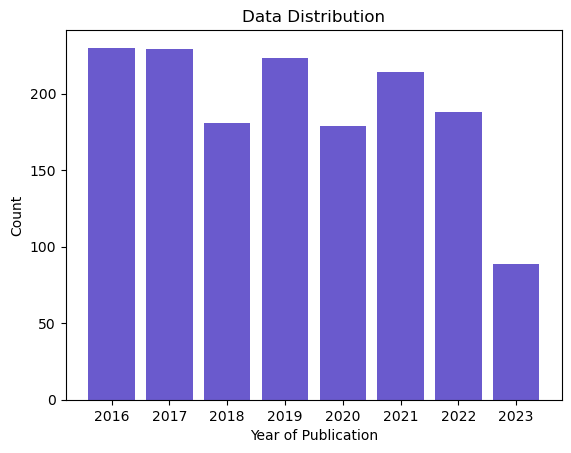

In [28]:
# Count the occurrence of each label
label_counts = df['Year'].value_counts()

# Get the labels and their counts
labels = label_counts.index.tolist()
counts = label_counts.tolist()

# Plot the data distribution
plt.bar(labels, counts, color = 'slateblue')

# Add labels and title
plt.xlabel('Year of Publication')
plt.ylabel('Count')
plt.title('Data Distribution')

# Show the plot
plt.show()

### <span style="color:darkblue"> * Words count </span>

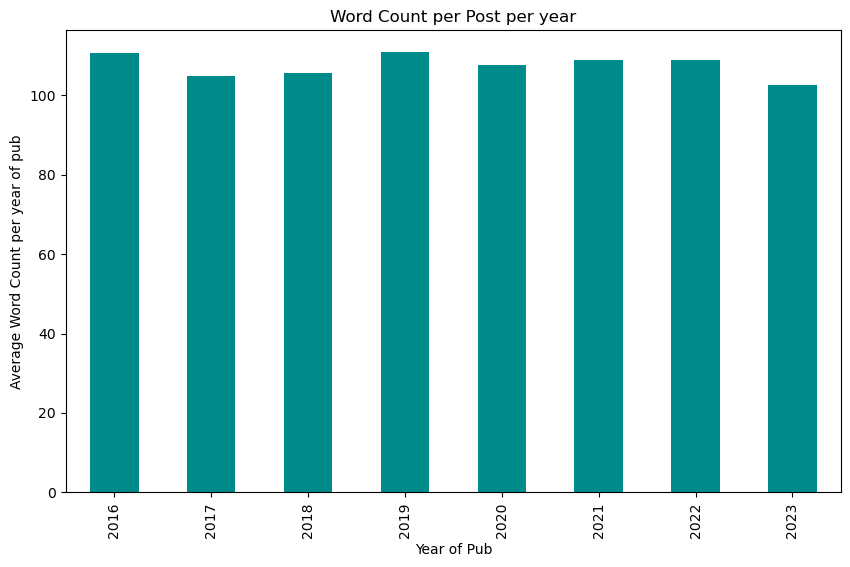

In [29]:
# Calculate word count for each tweet
df['word_count'] = df['Abstract'].str.split().apply(len)

# Group the data by disease and calculate the average word count per disease
disease_word_count = df.groupby('Year')['word_count'].mean()

# Plot the word count per tweet per category
disease_word_count.plot(kind='bar', figsize=(10, 6), color = 'darkcyan')
plt.xlabel('Year of Pub')
plt.ylabel('Average Word Count per year of pub')
plt.title('Word Count per Post per year')
plt.show()

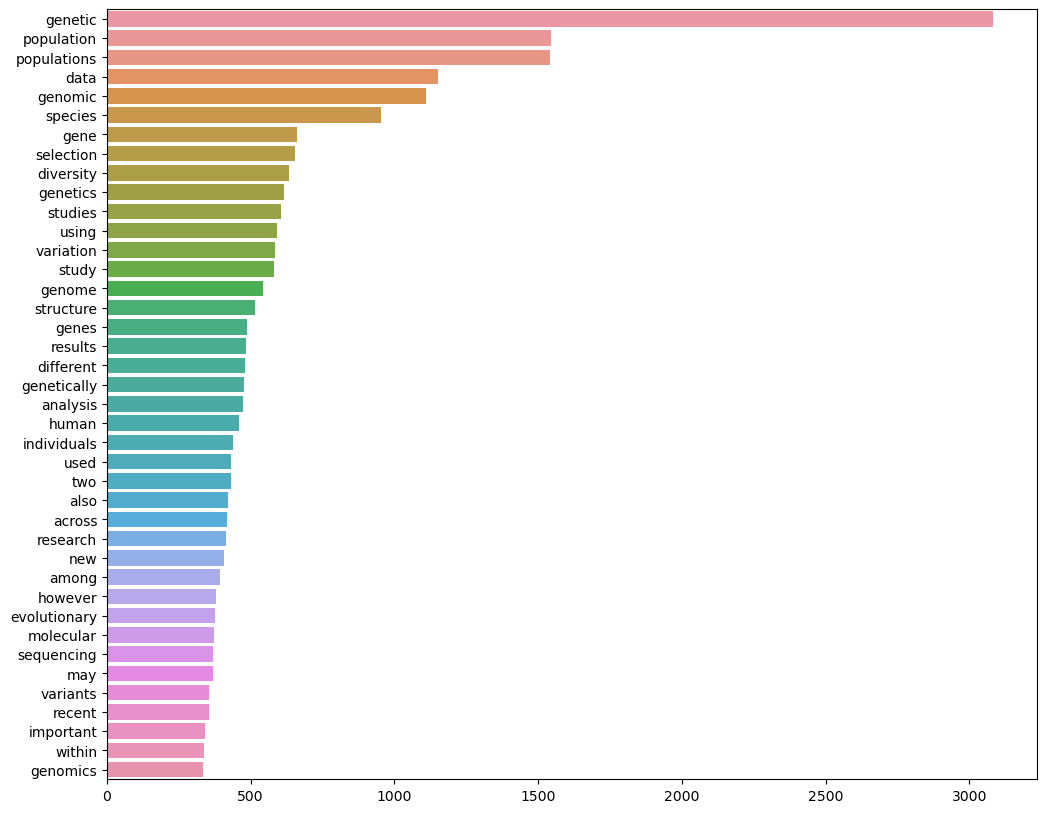

In [30]:
# Top Fréquence d'apparition des mots

def plot_top_non_stopwords_barchart(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize = (12,10))        
    sns.barplot(x = y, y = x)
    
plot_top_non_stopwords_barchart(df['Abstract'])

### <span style="color:darkblue"> * Document Term Matrix  </span>

In [31]:
df['Year'] = df['Year'].astype(str)
df_grouped = df[['Year', 'Abstract']].groupby('Year').agg(lambda x : ' '.join(x))
df_grouped.head()

Abstract
Year                                                   
2016  introgressive hybridization repeated backcross...
2017  bacteria reside externally accessible niches m...
2018  chinese genetics educators carried comprehensi...
2019  aim present study define mtdna variability pol...
2020  review outlines advances pigeonpea genomics br...

In [32]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer = 'word')
data = cv.fit_transform(df_grouped['Abstract'])
df_dtm = pd.DataFrame(data.toarray(), columns = cv.get_feature_names_out())
df_dtm.index = df_grouped.index
df_dtm

aa  aab  aare  ab  ababa  abalone  abalones  abandonment  abbababa  abc  \
Year                                                                            
2016   0    1     0   0      0        0         0            0         1    2   
2017   0    0     0   0      0        0         0            0         0    6   
2018   3    0     3   1      0        1         0            0         0    9   
2019   0    0     0   0      0        0         0            0         0    1   
2020   0    0     0   0      0        0         0            0         0    0   
2021   0    0     0   0      1        0         3            1         0    3   
2022   0    0     0   0      0        0         0            0         0    1   
2023   0    0     0   0      0        0         0            0         0    0   

      ...  über  βcatenin  βlactamase  δfst  δhf  δk  δpyre  μg  φst  ϕct  
Year  ...                                                                  
2016  ...     1         0           1     0    0   0      1   2    0    0  
2017  ...     0         1           0     0    0   0      0   0    2    0  
2018  ...     0         0           0     0    0   0      0   0    0    0  
2019  ...     0         0           0     0    0   2      0   0    0    1  
2020  ...     0         0           0     1    0   0      0   0    1    0  
2021  ...     0         0           0     0    0   0      0   0    1    0  
2022  ...     0         0           0     0    0   0      0   0    0    0  
2023  ...     0         0           0     0    2   0      0   0    0    0  

[8 rows x 16684 columns]

### <span style="color:darkblue"> * Words Cloud  </span>

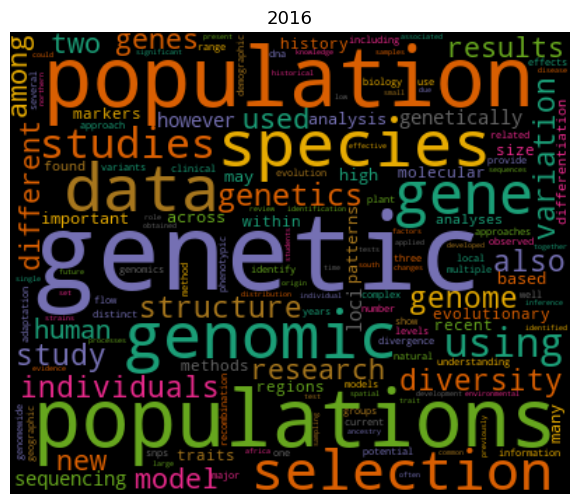

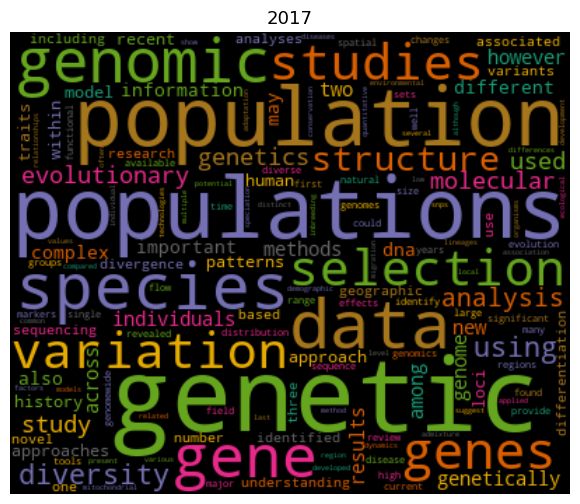

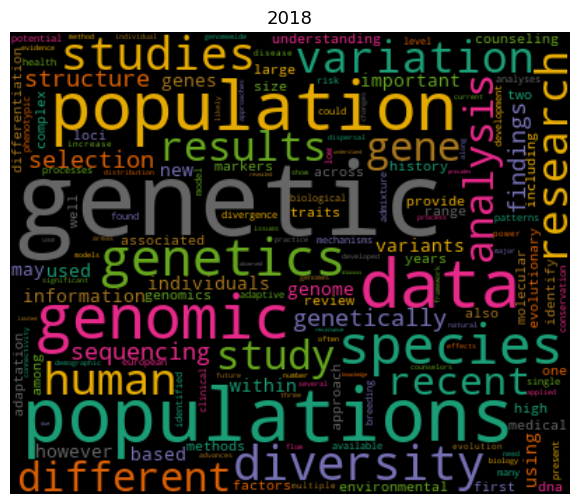

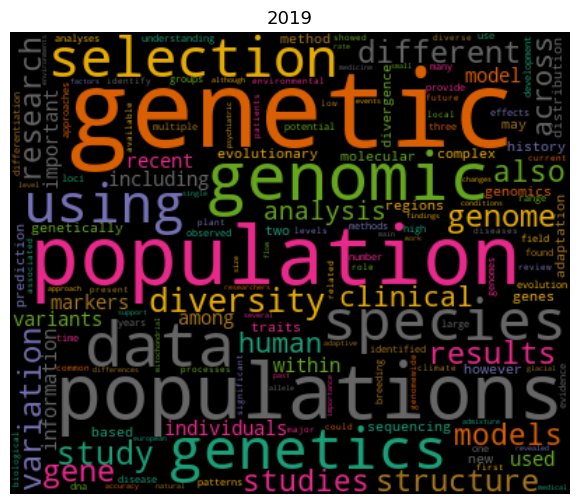

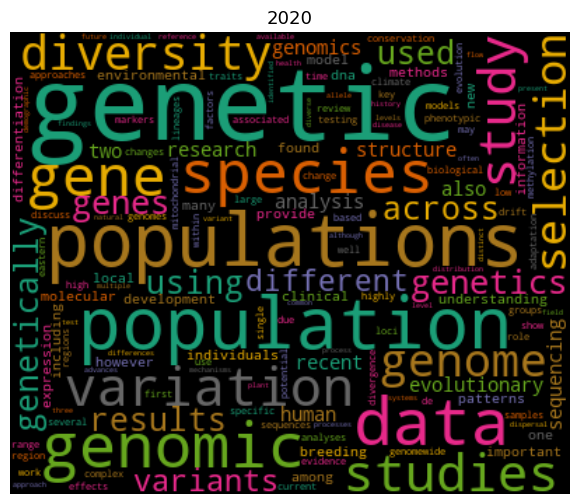

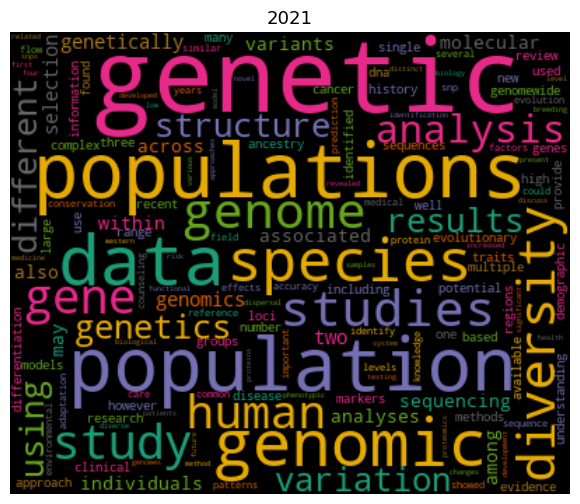

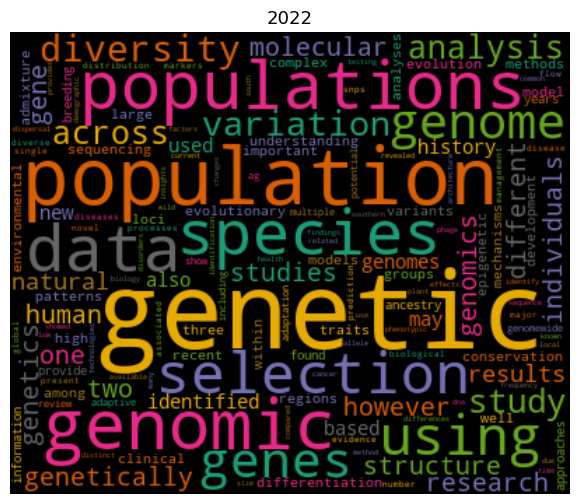

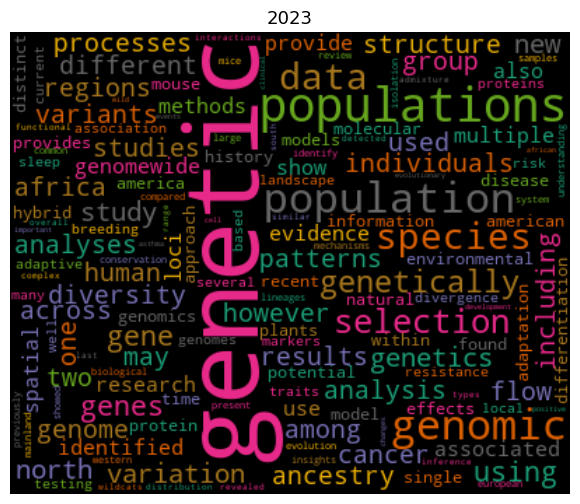

In [33]:
# Function for generating word clouds
def generate_wordcloud(data, title):
    wc = WordCloud(width = 400, height = 330, max_words = 150,colormap = "Dark2").generate_from_frequencies(data)
    plt.figure(figsize = (8, 6))
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title, 60)),fontsize = 13)
    plt.show()
    
# Transposing document term matrix
df_dtm = df_dtm.transpose()

# Plotting word cloud for each label
for index, label in enumerate(df_dtm.columns):
    generate_wordcloud(df_dtm[label].sort_values(ascending=False), label)

### <span style="color:darkblue"> **4) Modelisation**  </span>

### <span style="color:darkblue"> - Latent Dirichlet Allocation (LDA) </span>

In [34]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel

In [35]:
# Création d'un modèle de sac de mots en utilisant gensim
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [36]:
# Création du modèle 
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 10, id2word = dic, passes = 100, random_state = 42)

In [37]:
# Visualisation des topics
topics = []
for idx, topic in lda_model.print_topics(-1) :
    print("Topic: {} -> Words: {}".format(idx, topic))
    topics.append(topic)

Topic: 0 -> Words: 0.031*"population" + 0.022*"genetic" + 0.015*"specie" + 0.009*"gene" + 0.007*"diversity" + 0.007*"structure" + 0.006*"region" + 0.006*"study" + 0.006*"pattern" + 0.005*"variation"
Topic: 1 -> Words: 0.024*"genetics" + 0.008*"student" + 0.008*"field" + 0.007*"genetic" + 0.007*"research" + 0.007*"molecular" + 0.006*"science" + 0.006*"biology" + 0.005*"development" + 0.005*"teaching"
Topic: 2 -> Words: 0.036*"population" + 0.019*"genetic" + 0.014*"data" + 0.010*"study" + 0.009*"genomic" + 0.009*"method" + 0.008*"selection" + 0.008*"genome" + 0.007*"analysis" + 0.007*"individual"
Topic: 3 -> Words: 0.010*"methylation" + 0.008*"gene" + 0.008*"study" + 0.006*"model" + 0.005*"research" + 0.005*"strain" + 0.004*"genome" + 0.004*"used" + 0.004*"genomic" + 0.003*"finding"
Topic: 4 -> Words: 0.012*"goat" + 0.006*"breed" + 0.005*"genetic" + 0.004*"gene" + 0.004*"study" + 0.004*"habitat" + 0.003*"analysis" + 0.003*"panda" + 0.003*"level" + 0.003*"yeast"
Topic: 5 -> Words: 0.011*"

### <span style="color:darkblue"> * Cohérence du modèle  </span>

In [38]:
coherence_model_lda = CoherenceModel(model= lda_model, texts = corpus, dictionary = dic)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3909043977634979


### <span style="color:darkblue"> * Stockage du modèle  </span>

In [39]:
all_topic_model = []
for i in range(len(topics)):
    str = topics[i].split(' + ')
    topic_model = []
    for j in range(10):
        weight = str[j][0:5]
        word = str[j][7:len(str[j])-1]
        topic_model.append((weight, word))
    all_topic_model.append(topic_model)

In [40]:
df_topic_model = pd.DataFrame(all_topic_model)
df_topic_model.rename(index = {0: "Topic 1", 1: "Topic 2", 2: "Topic 3", 3: "Topic 4", 4: "Topic 5", 5: "Topic 6", 6: "Topic 7", 7: "Topic 8", 8: "Topic 9", 9: "Topic 10"})

0                    1                    2  \
Topic 1    (0.031, population)     (0.022, genetic)      (0.015, specie)   
Topic 2      (0.024, genetics)     (0.008, student)       (0.008, field)   
Topic 3    (0.036, population)     (0.019, genetic)        (0.014, data)   
Topic 4   (0.010, methylation)        (0.008, gene)       (0.008, study)   
Topic 5          (0.012, goat)       (0.006, breed)     (0.005, genetic)   
Topic 6        (0.011, genome)  (0.009, population)       (0.007, phage)   
Topic 7       (0.032, genetic)  (0.014, population)      (0.007, specie)   
Topic 8         (0.023, trait)     (0.018, genomic)  (0.014, prediction)   
Topic 9         (0.009, sweep)        (0.007, text)  (0.007, population)   
Topic 10      (0.025, genetic)     (0.010, disease)       (0.009, study)   

                              3                    4                    5  \
Topic 1           (0.009, gene)   (0.007, diversity)   (0.007, structure)   
Topic 2        (0.007, genetic)    (0.007, research)   (0.007, molecular)   
Topic 3          (0.010, study)     (0.009, genomic)      (0.009, method)   
Topic 4          (0.006, model)    (0.005, research)      (0.005, strain)   
Topic 5           (0.004, gene)       (0.004, study)     (0.004, habitat)   
Topic 6   (0.007, evolutionary)  (0.005, individual)       (0.005, trait)   
Topic 7      (0.005, diversity)      (0.005, effect)       (0.005, level)   
Topic 8           (0.013, data)    (0.013, breeding)   (0.011, selection)   
Topic 9        (0.006, formula)        (0.006, rate)  (0.006, resistance)   
Topic 10       (0.009, genomic)        (0.009, gene)    (0.009, research)   

                           6                      7                     8  \
Topic 1      (0.006, region)         (0.006, study)      (0.006, pattern)   
Topic 2     (0.006, science)       (0.006, biology)  (0.005, development)   
Topic 3   (0.008, selection)        (0.008, genome)     (0.007, analysis)   
Topic 4      (0.004, genome)          (0.004, used)      (0.004, genomic)   
Topic 5    (0.003, analysis)         (0.003, panda)        (0.003, level)   
Topic 6       (0.005, study)     (0.005, selection)    (0.005, evolution)   
Topic 7       (0.005, range)  (0.004, epidemiology)     (0.004, pathogen)   
Topic 8        (0.010, gene)         (0.009, model)        (0.008, plant)   
Topic 9       (0.006, model)          (0.005, site)         (0.004, gene)   
Topic 10      (0.008, human)       (0.008, variant)     (0.008, clinical)   

                            9  
Topic 1    (0.005, variation)  
Topic 2     (0.005, teaching)  
Topic 3   (0.007, individual)  
Topic 4      (0.003, finding)  
Topic 5        (0.003, yeast)  
Topic 6         (0.004, host)  
Topic 7         (0.004, gene)  
Topic 8     (0.008, accuracy)  
Topic 9         (0.004, hard)  
Topic 10    (0.008, genetics)

### <span style="color:darkblue"> * Visualisation du modèle  </span>

In [ ]:
!pip install pyLDAvis

In [41]:
import pyLDAvis.gensim_models

In [42]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.153148 -0.100156       1        1  26.091817
2     -0.145470 -0.061385       2        1  24.954822
9     -0.126937  0.186408       3        1  21.283970
7     -0.079647 -0.044839       4        1   7.335958
1      0.060096  0.200002       5        1   4.973231
6     -0.009511 -0.040923       6        1   4.823098
5      0.088955 -0.045954       7        1   2.931066
3      0.099319  0.008718       8        1   2.702982
8      0.121526 -0.059615       9        1   2.458813
4      0.144817 -0.042256      10        1   2.444242, topic_info=           Term         Freq        Total Category  logprob  loglift
40   population  2938.000000  2938.000000  Default  30.0000  30.0000
24      genetic  2906.000000  2906.000000  Default  29.0000  29.0000
82     genetics   558.000000   558.000000  Default  28.0000  28.0000
105       trait   356.000000   356.000000  Default  27.0000  27.0000
209     genomic  1039.000000  1039.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
392       using     8.942264   553.142674  Topic10  -6.0642  -0.4134
369      method     8.514158   494.962480  Topic10  -6.1132  -0.3513
117       china     7.271635    73.123781  Topic10  -6.2710   1.4033
345   different     7.478828   451.712961  Topic10  -6.2429  -0.3895
232      marker     7.037463   318.643318  Topic10  -6.3037  -0.1014

[725 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
8731      8  0.872822      abies
2194      2  0.142899    ability
2194      3  0.276272    ability
2194      4  0.362011    ability
2194      5  0.142899    ability
...     ...       ...        ...
276       4  0.627152      yield
7898      4  0.809752  yorkshire
3142      7  0.870577   zhoushan
832       1  0.992482       zone
455       4  0.849694       ∼kya

[1753 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 10, 8, 2, 7, 6, 4, 9, 5])